### Import clean data

df_langdetect.csv contains the information on the languages used in the df. However since the clean up might be better than when we originally did the classification We will first realign the two.



In [32]:
import pandas as pd
import text_utils

X_test = pd.read_csv("X_test.csv", index_col=0)
X_train = pd.read_csv("X_train.csv", index_col=0)
y_train = pd.read_csv("y_train.csv", index_col=0)

df = pd.merge(X_train, y_train, left_index=True, right_index=True)
df_lang = pd.read_csv('language_analysis/df_langdetect.csv', index_col=0)

In [33]:
df = text_utils.text_pre_processing(df)
df = df[['productid', 'imageid', 'prdtypecode', 'bool_description','merged_text']]

In [34]:
df.head()

,productid,imageid,prdtypecode,bool_description,merged_text
0,3804725264,1263597046,10,0,Olivia: Personalisiertes Notizbuch / 150 Seite...
1,436067568,1008141237,2280,0,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...
2,201115110,938777978,50,1,PILOT STYLE Touch Pen de marque Speedlink est ...
3,50418756,457047496,1280,0,Peluche Donald - Europe - Disneyland 2000 (Mar...
4,278535884,1077757786,2705,1,La Guerre Des Tuques - Luc a des idées de gran...


In [40]:
df_lang['lang'] = df_lang['gemini_lang'].fillna('fr')
df_lang.drop(['merged_text', 'merged_langdetect', 'gemini_lang', 'imageid', 'prdtypecode', 'bool_description'], inplace=True, axis = 1)

In [41]:
df_lang.head()

,productid,lang
0,3804725264,de
1,436067568,fr
2,201115110,fr
3,50418756,fr
4,278535884,fr


In [42]:
df_lang = pd.merge(df, df_lang, on = ['productid'], how='left')


In [43]:
df_lang.head()

,productid,imageid,prdtypecode,bool_description,merged_text,lang
0,3804725264,1263597046,10,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,de
1,436067568,1008141237,2280,0,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,fr
2,201115110,938777978,50,1,PILOT STYLE Touch Pen de marque Speedlink est ...,fr
3,50418756,457047496,1280,0,Peluche Donald - Europe - Disneyland 2000 (Mar...,fr
4,278535884,1077757786,2705,1,La Guerre Des Tuques - Luc a des idées de gran...,fr


In [52]:
df_lang.to_csv('language_analysis/df_lang.csv')

### Call DeepL for translations

In [ ]:
df_lang = pd.read_csv('language_analysis/df_lang.csv', index_col=0)
df_translate = df_lang.loc[df_lang['lang'] != 'fr']

DeepL has a free offering for their API which is restricted to 500,000 per month per account. Since we might not be able to simply translate everything, 
we want to start off understanding the elements that are not in French to evaluate which ones we want to translate first.

In [58]:
# getting some number to evaluate localization strategies
characters = int(df_translate['merged_text'].str.len().sum())

DeepL_free_limit = 500000

print(f'We have {characters:,} non French characters. Assuming that we use a free account of DeepL we would need {characters//DeepL_free_limit+1} accounts or months to localize everything into French')

We have 2,135,775 non French characters. Assuming that we use a free account of DeepL we would need 5 accounts or months to localize everything into French


In [74]:
# getting some number to evaluate localization strategies
characters = int(df_translate.loc[df_translate['lang'] == 'en']['merged_text'].str.len().sum())

DeepL_free_limit = 500000

print(f'We have {characters:,} English  characters. Assuming that we use a free account of DeepL we would need {characters//DeepL_free_limit+1} accounts or months to localize everything into French')

We have 2,003,897 English  characters. Assuming that we use a free account of DeepL we would need 5 accounts or months to localize everything into French


/tmp/ipykernel_120110/3979677289.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="lang", y=df_lang['merged_text'].apply(len), data=df_lang, palette="Greens")


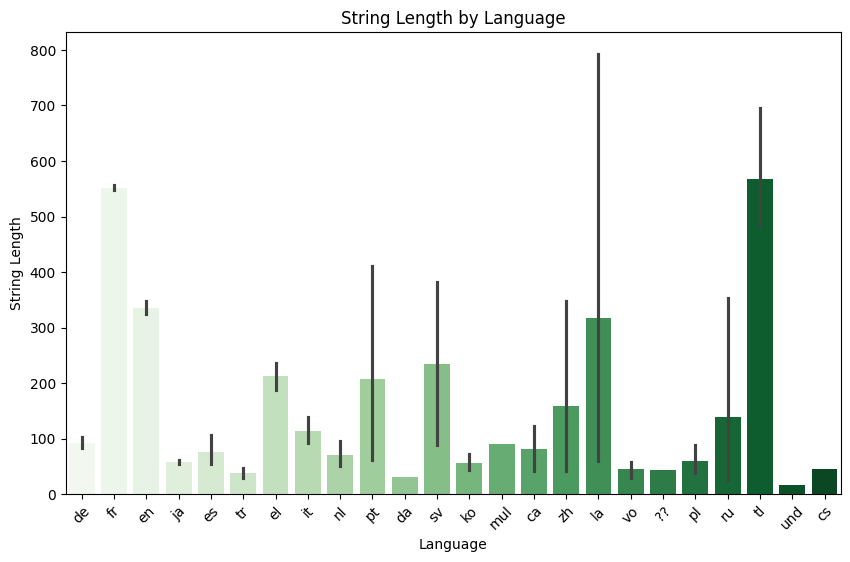

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x="lang", y=df_lang['merged_text'].apply(len), data=df_lang, palette="Greens")
plt.xlabel("Language")
plt.ylabel("String Length")
plt.title("String Length by Language")
plt.xticks(rotation=45)
plt.show()

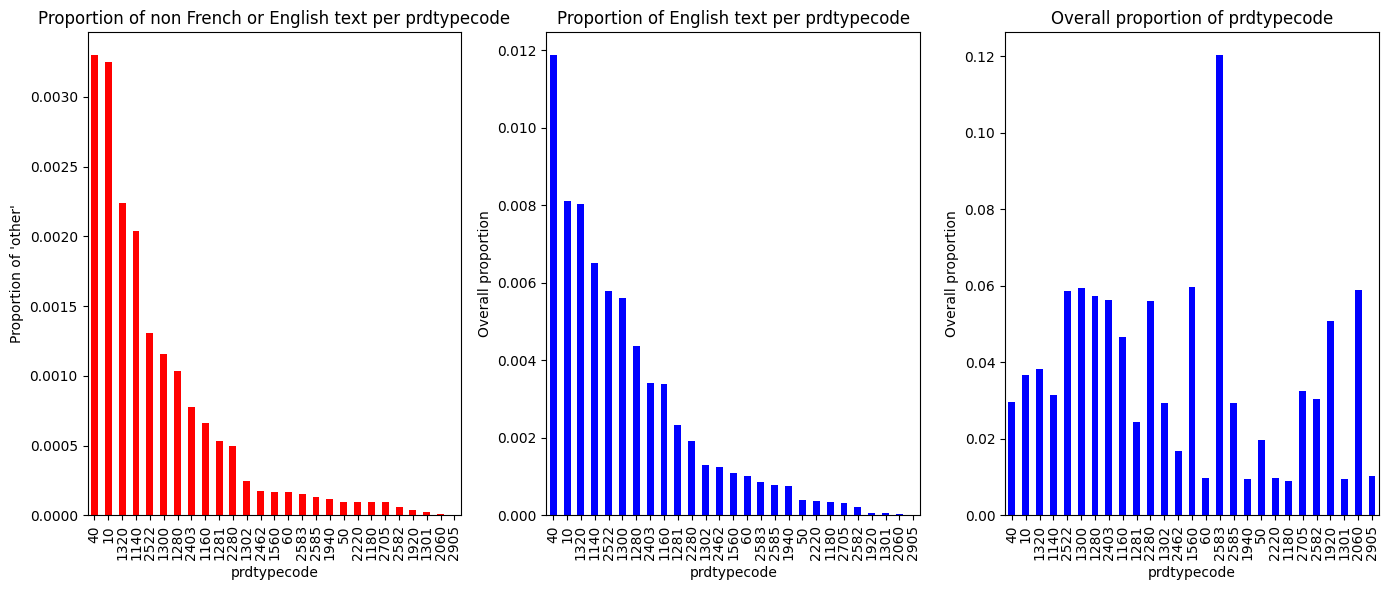

In [70]:
freq_counts = pd.crosstab(df_lang['prdtypecode'], df_lang['lang'].apply(lambda x: x if x in ['fr', 'en'] else 'other'), normalize=True)

# Compute "other" proportion per prdtypecode
other_freq = freq_counts['other'].sort_values(ascending=False)

en_freq = freq_counts['en'].sort_values(ascending=False)

# Compute overall proportion of each prdtypecode
overall_freq = df_lang['prdtypecode'].value_counts(normalize=True)

# Reindex `overall_freq` to match the order of `other_freq`
overall_freq = overall_freq.reindex(other_freq.index, fill_value=0)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=True)

# Plot proportion of "other" per prdtypecode
other_freq.plot(kind="bar", color="red", ax=axes[0])
axes[0].set_title("Proportion of non French or English text per prdtypecode")
axes[0].set_xlabel("prdtypecode")
axes[0].set_ylabel("Proportion of 'other'")

# Plot overall proportion of each prdtypecode (same order)
en_freq.plot(kind="bar", color="blue", ax=axes[1])
axes[1].set_title("Proportion of English text per prdtypecode")
axes[1].set_xlabel("prdtypecode")
axes[1].set_ylabel("Overall proportion")

# Plot overall proportion of each prdtypecode (same order)
overall_freq.plot(kind="bar", color="blue", ax=axes[2])
axes[2].set_title("Overall proportion of prdtypecode")
axes[2].set_xlabel("prdtypecode")
axes[2].set_ylabel("Overall proportion")

# Adjust layout
plt.tight_layout()
plt.show();

### Calling the DeepL API

The DeepL documentation used for this can be found https://developers.deepl.com/docs/getting-started/your-first-api-request